Contextual and non contextual modelling  
**did le-son use review and description together for topic modelling?**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities, matutils

from nltk.corpus import stopwords       
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import string

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [3]:
import pickle

with open('dataframe', 'rb') as file:
    df = pickle.load(file)

We'll pull out the text for nlp

In [4]:
fornlp = ['id', 'access', 'description', 'host_about', 'house_rules', 'interaction', 'name', 'neighborhood_overview',
         'notes', 'space', 'summary', 'transit', 'neighbourhood_Mission']

df = df[fornlp]

In [6]:
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8106 entries, 0 to 8586
Data columns (total 13 columns):
id                       8106 non-null int64
access                   4905 non-null object
description              8059 non-null object
host_about               6118 non-null object
house_rules              5888 non-null object
interaction              5431 non-null object
name                     8106 non-null object
neighborhood_overview    5952 non-null object
notes                    4872 non-null object
space                    6853 non-null object
summary                  7900 non-null object
transit                  5522 non-null object
neighbourhood_Mission    8106 non-null uint8
dtypes: int64(1), object(11), uint8(1)
memory usage: 831.2+ KB


airbnb listing layout:  
Summary/Description  
The Space  
Guest Access  


In [7]:
df.fillna(value = '', inplace = True)

def length(x):
    try:
        return len(x)
    except:
        return 1

df['blob'] = df['description'] + df['summary'] + df['space']

df['textlength'] = df.blob.map(lambda x: length(x))

mean 1712.62 median 1808.0 mode 0    1879
dtype: int64


(array([ 181.,  280.,  399.,  532.,  965., 1631., 1953., 1330.,  828.,
           7.]),
 array([   0.,  300.,  600.,  900., 1200., 1500., 1800., 2100., 2400.,
        2700., 3000.]),
 <a list of 10 Patch objects>)

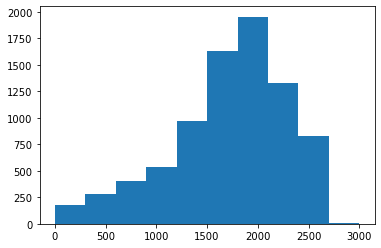

In [8]:
print('mean', round(df.textlength.mean(), 2), 'median', df.textlength.median(),'mode', df.textlength.mode())
plt.hist(df.textlength.values)

text cleaners

In [ ]:
#to get this regex syntax, not so easy
#let's take a look at documentation

def process_text_one(docs):
    """
    ---
    :param docs: Pandas series of texts to pre-process.
    :return: Pandas series of cleaned text.
    """
    # remove URLs and hyperlinks
    text_nourl = lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x)
    # remove @ names
    text_noname = lambda x: re.sub('(@[A-Za-z0-9_]+)', '', x)
    # remove hashtags
    text_nohash = lambda x: re.sub('(#[A-Za-z0-9_]+)', '', x)
    
    return docs.map(text_nourl).map(text_noname).map(text_nohash)

df['blob'] = process_text_one(df['blob'])
df.blob[:10]

In [ ]:
def process_text_two(docs):
    """
    ---
    :param docs: Pandas series of texts to pre-process.
    :return: Pandas series of cleaned text.
    """
    
    # remove numbers
    text_nonum = lambda x: re.sub(r'\d+', '', x)
    # remove the new line character
    text_nonewline = lambda x: re.sub('\n', '', x)
    # remove punctuation
    text_nopunct = lambda x: ''.join([char for char in x if char not in string.punctuation])
    # convert all letters to lowercase
    text_lower = lambda x: x.lower()
    # substitute multiple spaces with single space
    text_nospaces = lambda x: re.sub(r'\s+', ' ', x, flags=re.I)
    # remove all single characters
    text_single = lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x)
    
    return docs.map(text_nonum).map(text_nonewline).map(text_nopunct).map(text_lower).map(text_nospaces).map(text_single)

df.blob = process_text_two(df['blob'])
df.blob[:10]

In [ ]:
#wordcloud
#key words to add
# from wordcloud import WordCloud, STOPWORDS

# contextual_stop_words = ['san', 'francisco', 'golden', 'gate', 'bed']

# STOPWORDS = STOPWORDS.union(contextual_stop_words)

# wordcloud = WordCloud(background_color="white", max_words=500, width = 800, height = 400,
#                       contour_width=3, contour_color='steelblue', 
#                       stopwords = STOPWORDS)

# x = list(df['blob'])
# longstring = ','.join(x)
# wordcloud.generate(longstring)
# wordcloud.to_image()

In [ ]:
contextual_stop_words = ['san', 'francisco', 'golden', 'gate', 'bed']
STOPWORDS = ENGLISH_STOP_WORDS.union(contextual_stop_words)

def process_text_three(docs):
    """
    ---
    :param docs: Pandas series of texts to pre-process.
    :return: Pandas series of cleaned text.
    """
    # Setting stopwords
    contextual_stop_words = ['san', 'francisco', 'golden', 'gate', 'bed']
    STOPWORDS = ENGLISH_STOP_WORDS.union(contextual_stop_words)
    clean_text = []
    for textblob in docs:
        new_blob = []
        for word in textblob.split():
            if (word not in STOPWORDS) and (word not in string.punctuation):
                new_blob.append(word)
        clean_text.append(' '.join(new_blob))
    
    return clean_text

df.blob = process_text_three(df['blob'])
df.blob[:10]

In [ ]:
#DONE WITH THE CLEANING!

In [ ]:
analyzer = SentimentIntensityAnalyzer()
scores = []
for doc in df['blob']:
    vs = analyzer.polarity_scores(doc)
    scores.append(vs)

In [ ]:
df['senti_compound'] = [x['compound'] for x in scores]
df['senti_neg'] = [x['neg'] for x in scores] 
df['senti_neu'] = [x['neu'] for x in scores] 
df['senti_pos'] = [x['pos'] for x in scores] 

In [ ]:
# df['senti_compound'].describe()
plt.hist(df.senti_compound)

In [ ]:
0.086 + 0.786 +  0.128

In [ ]:
polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

In [ ]:
df['polarity'] = df.blob.map(polarity)
plt.hist(df.polarity)

In [ ]:
df['subjectivity'] = df.blob.map(subjectivity)
plt.hist(df.subjectivity)

In [ ]:
#very very nice distributions! now do topic modelling, and be done with the NLP part!
#LDA

sentimentscores = df[['senti_neg', 'senti_pos', 'senti_neu', 'polarity', 'subjectivity', 'textlength']]

sentimentscores

#### NMF

In [ ]:
contextual_stop_words = ['san', 'francisco', 'golden', 'gate', 'bed', 've', 'll']
STOPWORDS = ENGLISH_STOP_WORDS.union(contextual_stop_words)

corpus = list(df['blob'])

# create a CountVectorizer
vectorizer = CountVectorizer(stop_words=STOPWORDS)
doc_word = vectorizer.fit_transform(corpus)

# instantiate nmf model
nmf_model = NMF(20)
doc_topic = nmf_model.fit_transform(doc_word)


In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)

In [ ]:
topics = pd.DataFrame(doc_topic)
sentimentscores = sentimentscores.merge(topics, left_index = True, right_index = True)
sentimentscores

In [4]:
import pickle

with open('sentiscores', 'wb') as file:
    pickle.dump(sentimentscores, file)

NameError: name 'sentimentscores' is not defined

In [5]:
import pickle
import pandas as pd
import numpy as np
import re

with open('dataframe', 'rb') as file:
    df = pickle.load(file)
    
fornlp = ['id', 'access', 'description', 'host_about', 'house_rules', 'interaction', 'name', 'neighborhood_overview',
         'notes', 'space', 'summary', 'transit', 'neighbourhood_Mission']

df = df[fornlp]
df = df.fillna(value = '')
mission = df[df.neighbourhood_Mission == 1]

In [22]:
def process_text_one(docs):
    """
    ---
    :param docs: Pandas series of texts to pre-process.
    :return: Pandas series of cleaned text.
    """
    # remove URLs and hyperlinks
    text_nourl = lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x)
    # remove @ names
    text_noname = lambda x: re.sub('(@[A-Za-z0-9_]+)', '', x)
    # remove hashtags
    text_nohash = lambda x: re.sub('(#[A-Za-z0-9_]+)', '', x)
    
    return docs.map(text_nourl).map(text_noname).map(text_nohash)

mission['generator'] = process_text_one(mission['description'])
def process_text_two(docs):
    """
    ---
    :param docs: Pandas series of texts to pre-process.
    :return: Pandas series of cleaned text.
    """
    
    # remove numbers
    text_nonum = lambda x: re.sub(r'\d+', '', x)
    # remove the new line character
    text_nonewline = lambda x: re.sub('\n', '', x)
    # remove punctuation
    text_nopunct = lambda x: ''.join([char for char in x if char not in string.punctuation])
    # convert all letters to lowercase
    text_lower = lambda x: x.lower()
    # substitute multiple spaces with single space
    text_nospaces = lambda x: re.sub(r'\s+', ' ', x, flags=re.I)
    # remove all single characters
    text_single = lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x)
    
    return docs.map(text_nonum).map(text_nonewline).map(text_nopunct).map(text_lower).map(text_nospaces).map(text_single)

mission['generator'] = process_text_two(mission['generator'])
    

corpus = mission[mission.generator != '']['generator']


/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: 10

In [24]:

print(corpus[9:10].values)

['come fall in love with our charming large elegant bedroom bath home while you enjoy all of the attractions cultural opportunities and beauty which has made san francisco one of the worlds premiere destinations if this writeup sounds too good to be true it almost is its our small slice of heaven in the middle of san francisco this year old brick carriage house was recently completely and meticulously restored to its original victorian charm and beauty while incorporating wealth of modern amenities the house is set back off the street behind another building and courtyard all part of this property providing secluded countrylike atmosphere while still in the heart of the city the following are some of the specific amenities and features of the house central heating granite countertops wholehouse stereo wholehouse wireless and wired highspeed internet wholehouse music and video distribution system with hundreds of movies and over cds t']


In [7]:
# Neural Net Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Neural Net Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding

# Neural Net Training
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [8]:
max_words = 50000 # Max size of the dictionary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(corpus.values)
sequences = tokenizer.texts_to_sequences(corpus.values)

# Flatten the list of lists resulting from the tokenization. This will reduce the list
# to one dimension, allowing us to apply the sliding window technique to predict the next word
text = [item for sublist in sequences for item in sublist]
vocab_size = len(tokenizer.word_index)

In [9]:
vocab_size

5602

In [10]:
sentence_len = 20
pred_len = 1
train_len = sentence_len - pred_len
seq = []
# Sliding window to generate train data
for i in range(len(text)-sentence_len):
    seq.append(text[i:i+sentence_len])
# Reverse dictionary to decode tokenized sequences back to words
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# Each row in seq is a 20 word long window. We append he first 19 words as the input to predict the 20th word
trainX = []
trainy = []
for i in seq:
    trainX.append(i[:train_len])
    trainy.append(i[-1])

In [11]:
# define model
model = Sequential([
    Embedding(vocab_size+1, 50, input_length=train_len),
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(100, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 50)            280150    
_________________________________________________________________
lstm (LSTM)                  (None, 19, 100)           60400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 5602)              565802    
Total params: 996,852
Trainable params: 996,852
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trainy

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
model.fit(np.array(trainX), np.array(pd.get_dummies(np.array(trainy))), batch_size=64, epochs=5)

Train on 112584 samples
Epoch 1/5
112584/112584 [==============================] - 224s 2ms/sample - loss: 6.4148 - accuracy: 0.0584
Epoch 2/5
112584/112584 [==============================] - 186s 2ms/sample - loss: 5.9357 - accuracy: 0.1036
Epoch 3/5
112584/112584 [==============================] - 174s 2ms/sample - loss: 5.5595 - accuracy: 0.1360
Epoch 4/5
112584/112584 [==============================] - 225s 2ms/sample - loss: 5.1969 - accuracy: 0.1621
Epoch 5/5
112584/112584 [==============================] - 247s 2ms/sample - loss: 4.8805 - accuracy: 0.1892


In [15]:
model_list = [model]

def gen(model,seq,max_len = 20):
    ''' Generates a sequence given a string seq using specified model until the total sequence length
    reaches max_len'''
    # Tokenize the input string
    tokenized_sent = tokenizer.texts_to_sequences([seq])
    max_len = max_len+len(tokenized_sent[0])
    # If sentence is not as long as the desired sentence length, we need to 'pad sequence' so that
    # the array input shape is correct going into our LSTM. the `pad_sequences` function adds 
    # zeroes to the left side of our sequence until it becomes 19 long, the number of input features.
    while len(tokenized_sent[0]) < max_len:
        padded_sentence = pad_sequences(tokenized_sent[-19:],maxlen=19)
        op = model.predict(np.asarray(padded_sentence).reshape(1,-1))
        tokenized_sent[0].append(op.argmax()+1)
        
    return " ".join(map(lambda x : reverse_word_map[x],tokenized_sent[0]))

def test_models(test_string,sequence_length= 50, model_list = model_list):
    '''Generates output given input test_string up to sequence_length'''
    print('Input String: ', test_string)
    for counter,model in enumerate(model_list):
        print("Model ", counter+1, ":")
        print(gen(model,test_string,sequence_length))
    pass


In [28]:
test_models('Come fall in love with our charming large elegant bedroom bath home with', 25)

Input String:  Come fall in love with our charming large elegant bedroom bath home with
Model  1 :
come fall in love with our charming large elegant bedroom bath home with an extra and dryer the kitchen with an adventurers and the house is located in the mission district and the mission district is located in
